# <font color=navy> 5. 사전확률분포의 결정 </font>

적절한 사전분포를 어떻게 고를 것인가? 
## 5.1 주관적인 사전확률분포 vs. 객관적인 사전확률분포 
### 객관적인 사전확률분포 (objective/non-informative prior)
- 최대한 데이터가 사후분포에 미치는 영향을 크게 할 수 있는 방법
- flat prior (uniform distbution)이 주로 사용 
- 가능한 모수 공간에서 특별히 어떤 값을 선호하지 않는다는 원칙 ("Principle of Indifference")
    - 이항확률분포의 $p$에 대한 사전분포를 $Unif(0,1)$로 설정 
    - $Unif(0.5,1)$은 객관적인 사전분포가 아님
    

### 주관적인 사전확률분포 (subjective prior) 
- 특정 영역에서 더 큰 확률을 갖는 확률분포를 사전분포로 사용
- 해당 영역에 편향된 추론 결과를 가져옴

In [37]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

import datetime
import collections
import pandas as pd

import pymc3 as pm
import theano.tensor as tt
from theano.tensor.nlinalg import matrix_inverse, diag, matrix_dot

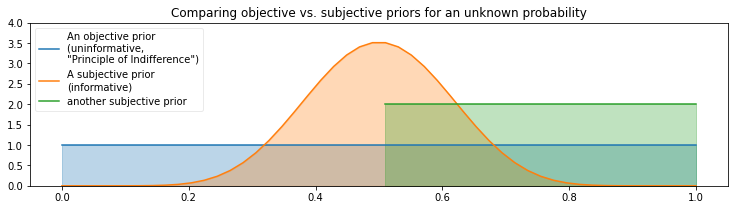

In [38]:
figsize(12.5,3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1)
y1, y2 = stats.beta.pdf(x, 1,1), stats.beta.pdf(x, 10,10)

p = plt.plot(x, y1, 
    label='An objective prior \n(uninformative, \n"Principle of Indifference")')
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x,y2 ,
     label = "A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x[25:], 2*np.ones(25), label = "another subjective prior")
plt.fill_between(x[25:], 0, 2, color = p[0].get_color(), alpha = 0.3)

plt.ylim(0,4)

plt.ylim(0, 4)
leg = plt.legend(loc = "upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability");

### 사전분포의 결정 
- 객관적인 사전확률분포나 주관적인 사전확률분포는 보통 해결하려는 문제에 따라 선택
- Example: 과학 연구의 경우 결과에 대한 편향을 제거해야 하므로 객관적인 사전확률분포를 선택

- 사전분포의 결정은 모델링 과정의 일부 
    > 모델이 적합한 이후에는 사후확률분포를 살펴보아야 하고, 이치에 맞는지 확인해야 한다. 만일 사후확률분포가 이치에 맞지 않는다면 모델에 포함되지 않은 사전 정보가 추가로 필요하다는 것을 의미한다. 그리고 이전에 사용한 사전확률분포의 가정에 위배된다는 것을 의미한다. 그래서 이전으로 돌아가 사전확률분포가 외부 정보와 조화되도록 변경하는 것이 적절하다. *- Andrew Gelman-*
    
    
- 큰 범위의 uniform distribution은 좋은 객관적인 사전분포이지만 직관적이지 않은 값이 할당될 수 있다. (엄청 크거나 작은 수가 실제로 그럴 듯한 값인가?) 
    - 매우 큰 $\sigma$ 값을 사용한 $N(0, \sigma^2)$ 또는 양의 영역에서 꼬리가 두터운 지수확률변수가 좋은 대안
    

## 5.2 Conjugate priors (켤레 사전분포)
### Example
$$
\overbrace { \text{베타} }^{ \text{사전확률분포} } \cdot \overbrace { \text{이항} }^{ \text{데이터} } =\overbrace { \text{베타} }^{ \text{사후확률분포} } 
$$ 
- Binomial 분포의 성공확률 $p$의 사전분포를 Beta 분포로 설정하면 사후분포 역시 Beta 분포로 우리가 잘 아는 분포가 되기 때문에 MCMC 없이 적분을 통해 평균, 분산을 쉽게 계산 가능
- 사후분포로부터의 random number 추출이 손쉬움 

### **Conjugate priors**
$X$가 잘 알려진 분포($f_{\alpha}$)에서 나왔다고 가정하자. 특정한 분포 $f_{\alpha}$에 대해 다음과 같은 사전확률분포 $p_{\beta}$가 존재할 수 있다.

$$
\overbrace { p_{\beta} }^{ \text{사전확률분포} } \cdot \overbrace { f_{\alpha}(X) }^{ \text{데이터} } =\overbrace { p_{\beta '} }^{ \text{사후확률분포} } 
$$

- $\alpha, \beta, \beta '$: 모수들의 집합
- 사전확률분포 $p$는 위의 관계를 만족시키면 이를 $f_{\alpha}$의 conjugate prior라고 한다. 

### Note
- 켤레 사전확률분포는 객관적인 사전확률분포는 아니다. 
- 전형적으로 켤레 사전확률분포는 단순하고 1차원적인 문제에만 존재한다. 복잡한 구조로 된 좀더 큰 문제의 경우 켤레 사전확률분포를 찾을 거라는 보장이 없다.

### 대표적인 conjugate priors 


|   Likelihood |&nbsp;  &nbsp;&nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp; Prior &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp; &nbsp;  &nbsp; | &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp; &nbsp;  &nbsp;&nbsp;  &nbsp; &nbsp; &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp; Posterior &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp; |
|:----------:|:-----:|:---------:|
|  Bernoulli($\theta$)  | Beta$(\alpha, \beta)$       |   Beta$(\alpha + n \bar x, \beta+n(1-\bar x))$        |
| Poisson$(\lambda)$ | Gamma $(\alpha, \beta)$| Gamma$(\alpha+n\bar x, \beta+n)$ |
| Multinomial$(\theta)$ | Dirichlet$(\alpha)$|Dirichlet$(\alpha+n\bar x)$|
|$N(\mu, \sigma^2)$, known $\sigma^2$|$N(\mu_0, \sigma_0^2)$| $N( (\frac{\mu_0}{\sigma_0^2} + \frac{n \bar x}{\sigma^2})/(\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}), 1/(\frac {1} {\sigma_0^2} + \frac {n} {\sigma^2}) )$|
|$N(\mu, \sigma^2)$, known $\mu$| IG$(\alpha, \beta)$ | IG$(\alpha +\frac n 2, \beta + \frac{n(\bar x -\mu)^2}{2})$|
|$N(\mu, \Sigma)$, known $\mu$| Inv-Wishart$(\nu_0, S_0)$| Inv-Wishart$(\nu_0+n, S_0 + n \bar S)$|

## 5.3 Jeffreys Priors
- Flat prior가 과연 정말 객관적인 prior 일까?
- Flat prior는 transformation invariant의 성질이 없다. 
    - 변환을 하게 되면 더이상 flat prior가 아님.
    
#### Example
$$ X \sim Bernoulli(\theta)$$
    $$ p(\theta)= 1, ~~ 0<\theta<1$$

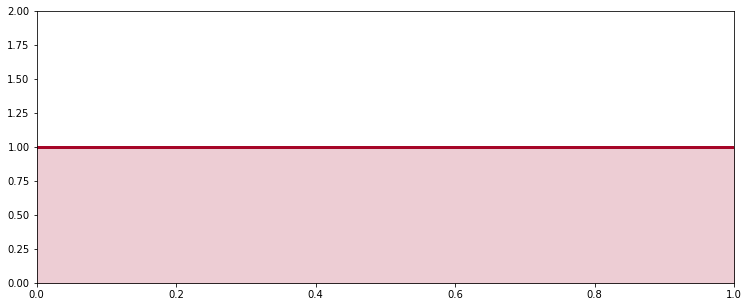

In [39]:
figsize(12.5, 5)

x = np.linspace(0.000 ,1, 150)
y = np.linspace(1.0, 1.0, 150)
lines = plt.plot(x, y, color="#A60628", lw = 3)
plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.ylim(0, 2);

$\theta$를 $\psi = log \frac{\theta}{1-\theta}$으로 변환을 하면 $\psi$에 대한 사전분포는 아래와 같다. 

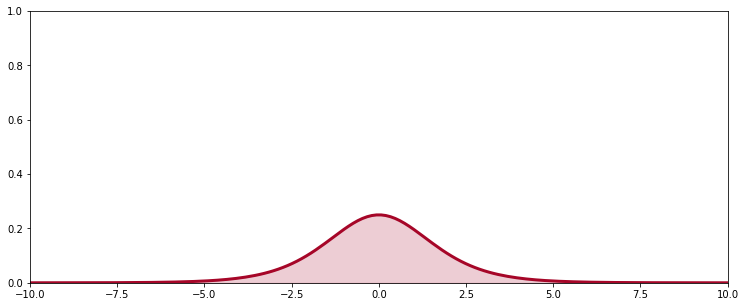

In [40]:
figsize(12.5, 5)

psi = np.linspace(-10 ,10, 150)
y = np.exp(psi) / (1 + np.exp(psi))**2
lines = plt.plot(psi, y, color="#A60628", lw = 3)
plt.fill_between(psi, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.ylim(0, 1);

#### Jeffreys prior
- 모수를 변환하는 것에 의해 의도치 않게 주관적인 사전분포가 되는 것을 막기 위한 사전분포 
- 아래와 같이 정의된다. 
$$p_J(\theta) \propto \mathbf{I}(\theta)^\frac{1}{2}$$
$$\mathbf{I}(\theta) = - \mathbb{E}\bigg[\frac{d^2 \text{ log } p(X|\theta)}{d\theta^2}\bigg]$$

$\mathbf{I}(\theta)$는 *Fisher information*

## 5.3 $N$이 증가할 때 사전확률분포의 효과
- 관측치의 양이 증가할수록 사전확률분포의 중요성은 약화된다.

$$
p\left( { \theta }|{ X } \right) \propto \underbrace { p\left( { X }|{ \theta } \right) }_{ \text{Likelihood} }  \cdot  \overbrace { p(\theta) }^{ \text{Prior} } 
$$



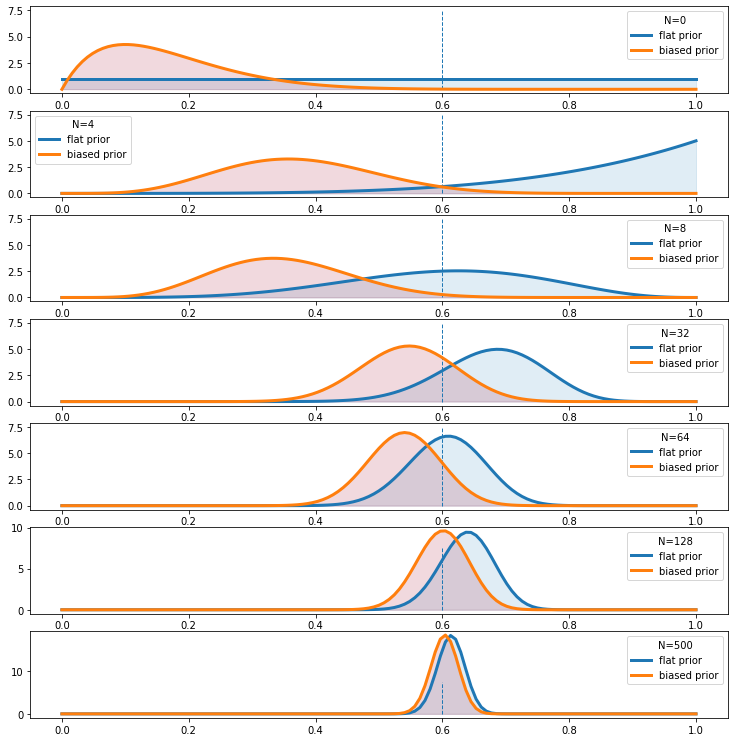

In [41]:
figsize(12.5, 15)

p = 0.6
beta1_params = np.array([1.,1.])
beta2_params = np.array([2,10])
beta = stats.beta

x = np.linspace(0.00, 1, 125)
data = stats.bernoulli.rvs(p, size=500)

plt.figure()
for i,N in enumerate([0, 4, 8, 32, 64, 128, 500]):
    s = data[:N].sum() 
    plt.subplot(8,1,i+1)
    params1 = beta1_params + np.array([s, N-s])
    params2 = beta2_params + np.array([s, N-s])
    y1,y2 = beta.pdf(x, *params1), beta.pdf( x, *params2)
    plt.plot(x,y1, label = "flat prior", lw =3)
    plt.plot(x, y2, label = "biased prior", lw= 3)
    plt.fill_between(x, 0, y1, color ="#348ABD", alpha = 0.15) 
    plt.fill_between(x, 0, y2, color ="#A60628", alpha = 0.15) 
    plt.legend(title = "N=%d" % N)
    plt.vlines(p, 0.0, 7.5, linestyles = "--", linewidth=1)
    #plt.ylim( 0, 10)#


## 5.4 Example: 주식수익률

$S_t$가 $t$영업일의 주가라면 $t$일의 일간수익률은 다음과 같다.

$$
r_t = \frac{S_t - S_{t-1}}{S_{t-1}}
$$

주식의 **일간기대수익률**은 $\mu = E[r_t]$로 계산된다.
- 주가에는 노이즈가 많고 주가는 시간의 흐름에 따라 변하기 때문에 대량의 과거 데이터를 사용하여 일간기대수익률을 계산하는 것은 좋지 않다. 

- 펀드매니저에게 질문: "애플(AAPL), 구글(GOOG), 테슬라(TSLA), 아마존(AMZN)의 수익률은 어떤 모습일까요?"
    - 펀드매니저는 경험과 산업에 대한 전문지식에 의존하여 사전확률분포를 아래와 같은 정규분포로 예상하였다. $\Rightarrow$ **주관적인 사전분포**


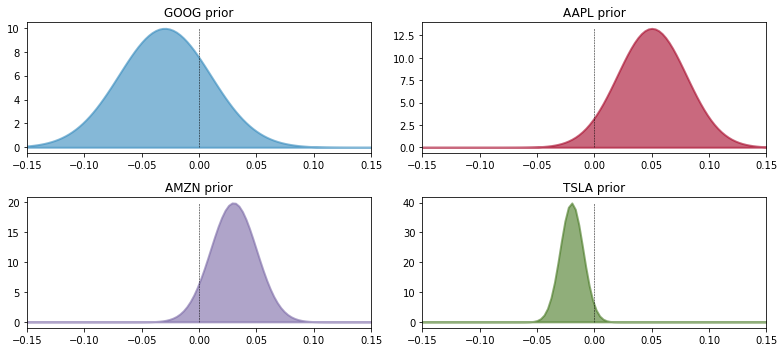

In [42]:
figsize(11., 5)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {"GOOG":(-0.03, 0.04), 
                       "AAPL":(0.05, 0.03),
                       "AMZN": (0.03, 0.02),
                       "TSLA": (-0.02, 0.01), 
                 }

for i, (name, params) in enumerate(expert_prior_params.items()):
    plt.subplot(2, 2, i+1)
    y = normal.pdf(x, params[0], scale = params[1])
    #plt.plot( x, y, c = colors[i] )
    plt.fill_between(x, 0, y, color = colors[i], linewidth=2,
                     edgecolor = colors[i], alpha = 0.6)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k","--", linewidth = 0.5)
    plt.xlim(-0.15, 0.15)
plt.tight_layout()


- "계란은 한바구니에 담지마라!": 분산투자의 원칙
    - 수익률의 공분산 행렬은 어떻게 생겼을까?
    - 서로 상관관계가 높은 종목은 함께 투자하는 것은 좋지 않기 때문에 공분산 행렬도 고려할 필요가 있다.
    - 공분산 행렬의 사전분포로 Wishart distribution을 사용 

#####  데이터 불러오기 

In [43]:
# pip install --upgrade pandas
# pip install --upgrade pandas-datareader

In [44]:
#@title External Stock Data
import datetime
import collections
import pandas_datareader.data as web
import pandas as pd

n_observations = 100 #@param {type:"slider", min:50, max:200, step:10}
#@markdown We will truncate the the most recent 100 days by default.
stock_1 = "GOOG" 
stock_2 = "AAPL" 
stock_3 = "AMZN" 
stock_4 = "TSLA" 
stocks = [stock_1, stock_2, stock_3, stock_4]

start_date = "2019-09-01" #@param {type:"date"}
end_date = "2021-08-31" #@param {type:"date"}

CLOSE = 3

stock_closes = pd.DataFrame()

for stock in stocks:
    stock_data = web.DataReader(stock,'yahoo', start_date, end_date)
    dates = stock_data.index.values
    x = np.array(stock_data)
    stock_series = pd.Series(x[1:,CLOSE].astype(float), name=stock)
    stock_closes[stock] = stock_series

In [45]:
stock_closes = stock_closes[-(n_observations+1):]

In [46]:
stock_returns = stock_closes.pct_change()[1:]
dates = dates[-n_observations:]
stock_returns_obs = stock_returns.values.astype(dtype=np.float32)

<Figure size 900x288 with 0 Axes>

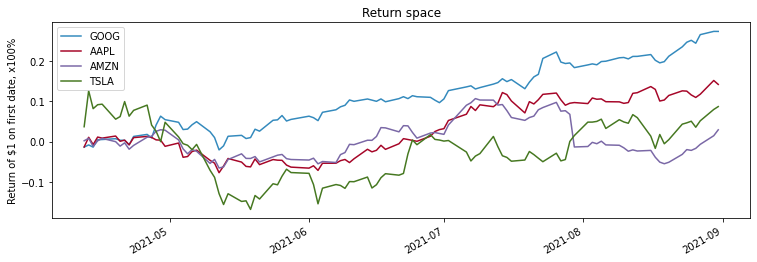

In [55]:
plt.figure(figsize(12.5, 4))

cum_returns = np.cumprod(1 + stock_returns) - 1
cum_returns.index = dates
cum_returns.plot(color=colors)

plt.legend(loc = "upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%")
plt.show()

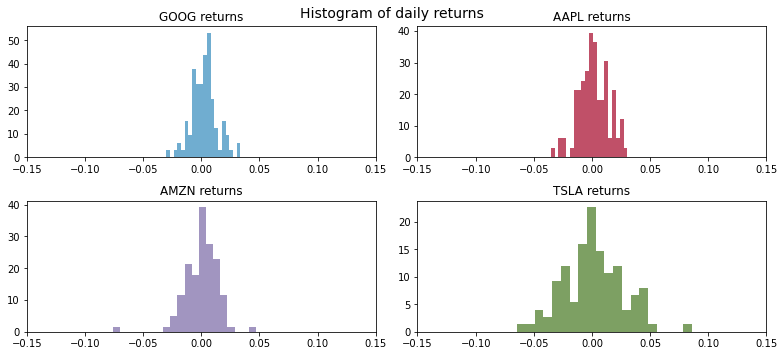

In [56]:
figsize(11., 5 )

for i, _stock in enumerate(stocks):
    plt.subplot(2,2,i+1)
    plt.hist(stock_returns[_stock], bins=20,
             density = True, histtype="stepfilled",
             color=colors[i], alpha=0.7)
    plt.title(_stock + " returns")
    plt.xlim(-0.15, 0.15)

plt.tight_layout()
plt.suptitle("Histogram of daily returns", size =14);


##### 모델 설정과 샘플링

In [57]:
# 앞에서 지정한 전문가 의견을 사전확률분포 모수로 사용
prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

init = stock_returns.cov() # data의 공분산 행렬을 initial value로 사용 

with pm.Model() as model:
    cov_matrix = pm.WishartBartlett("covariance", np.diag(prior_std**2), 10, testval = init)
    mu = pm.Normal("returns", mu=prior_mu, sd=1, shape=4)

Added new variable covariance_c to model diagonal of Wishart.
Added new variable covariance_z to model off-diagonals of Wishart.


In [58]:
with model:
    obs = pm.MvNormal("observed returns", mu=mu, cov=cov_matrix, observed=stock_returns)
    step = pm.NUTS()
    trace = pm.sample(5000, step=step, chains=1 )

/Users/yeojinchung/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Sequential sampling (1 chains in 1 job)
NUTS: [returns, covariance_z, covariance_c]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 40 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


##### 사후분포

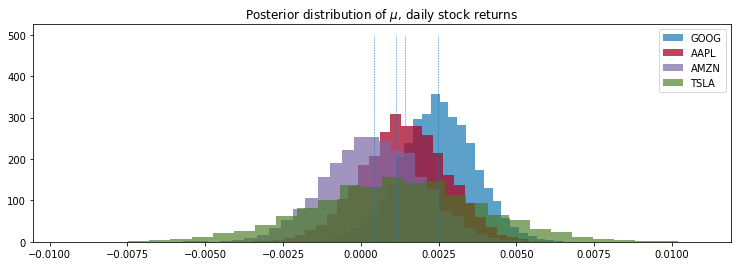

In [59]:
figsize(12.5,4)

#examine the mean return first.
mu_samples = trace["returns"]

for i in range(4):
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", density=True, color = colors[i], 
             label = "%s" % stock_returns.columns[i])

plt.vlines(mu_samples.mean(axis=0), 0, 500, linestyle="--", linewidth = .5)

plt.title("Posterior distribution of $\mu$, daily stock returns")
plt.legend();

- Google의 수익율 평균이 다른 종목보다 높음. 거의 양의 수익률
- Tesla 수익율 평균의 사후분포는 변동성이 크고 음의 영역에도 넓게 퍼져있음

**평균의 사후분포를 위의 데이터 분포와 같은 범위에서 그려보면 어떻게 될까?**

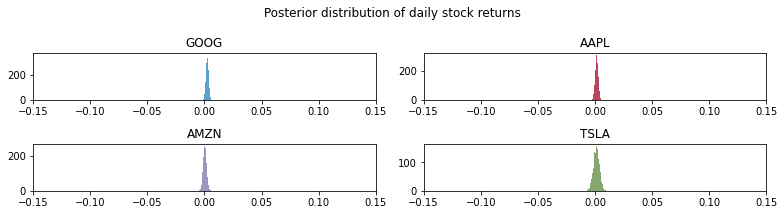

In [60]:
figsize(11.0,3)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", density=True, color = colors[i],
             label = "%s" % stock_returns.columns[i])
    plt.title("%s" % stock_returns.columns[i])
    plt.xlim(-0.15, 0.15)
    
plt.suptitle("Posterior distribution of daily stock returns")
plt.tight_layout()

- 사전분포에 비해 사후분포의 값들이 훨씬 0에 가까운(절대값이 작은) 경향이 있다. 왜?
    - 주가 데이터는 signal-to-noise ratio가 매우 낮다. (평균에 비해 분산이 큼) 
- 통계적 추론이 어렵다.

**사후 공분산 행렬은 어떤 형태일까?**
- 상관계수 행렬과 표준편차로 분해해서 비교

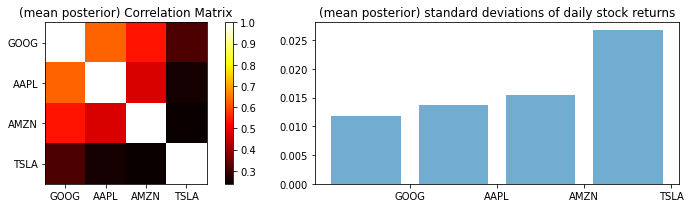

In [65]:
cov_samples = trace["covariance"]
mean_covariance_matrix = cov_samples.mean(axis=0)

def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A


plt.subplot(1,2,1)
plt.imshow(cov2corr(mean_covariance_matrix) , interpolation="none", 
                cmap = "hot") 
plt.xticks(np.arange(4), stock_returns.columns)
plt.yticks(np.arange(4), stock_returns.columns)
plt.colorbar(orientation="vertical")
plt.title("(mean posterior) Correlation Matrix")

plt.subplot(1,2,2)
plt.bar(np.arange(4), np.sqrt(np.diag(mean_covariance_matrix)),
        color = "#348ABD", alpha = 0.7)
plt.xticks(np.arange(4) + 0.5, stock_returns.columns);
plt.title("(mean posterior) standard deviations of daily stock returns")

plt.tight_layout();


- Tesla의 변동성이 높다. 
- Google과 Apple의 상관계수가 높다.